# DDPLKO Moduł 7 - praca domowa - HPO

To siódma praca domowa w Programie szkoleniowym Klasyfikacja obrazu od Deep Drive PL

Twoim zadaniem w tym module będzie jendo z 2:

Opcja 1:
- [ ] Na bazie pracy domowej z Transfer learningiem, data augmentation
- [ ] Wykorzystaj HPO (np. Optunę, Hyperopta bądź KerasTuner) by dobrać parametry treningu (optymalizator, LR), data augmentation (zakresy wartości)
- [ ] Udostępnij wykres na Discordzie `#klasyfikacja-wyniki` (val acc - porównanie model przed i po HPO)

Opcja 2 (mniejsza moc obliczeniowa):
- [ ] Na bazie pracy domowej ze zbiorem **QuickDraw**
- [ ] Wykorzystaj HPO (np. Optunę, Hyperopta bądź KerasTuner) by dobrać parametry treningu (optymalizator, LR), i architektury sieci (liczba warstw, dropout, pooling)
- [ ] Pracuj na podzbiorze max 100k przykładów
- [ ] Udostępnij wykres na Discordzie `#klasyfikacja-wyniki` (val acc - porównanie model przed i po HPO)

Możesz extra (czyli opcjonalne rzeczy):
- Spróbować użyć AutoKeras by znaleźć architekturę dla problemu

## Quickdraw 10 class dataset preparation

In [28]:
import urllib
import numpy as np
import matplotlib.pyplot as plt
import os

In [29]:
class_names=['donut', 'alarm clock', 'baseball', 'blueberry', 'cookie', 
             'compass', 'hamburger', 'soccer ball', 'wheel', 'watermelon']

In [30]:
for name in class_names:
    url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/%s.npy'%name
    file_name = url.split('/')[-1].split('?')[0]

    url = url.replace(' ','%20')
    
    if not os.path.isfile(file_name):
        print(url, '==>', file_name)
        urllib.request.urlretrieve(url, file_name)

In [78]:
data = []
for name in class_names:
    file_name = name+'.npy'
    data.append(np.load(file_name, fix_imports=True, allow_pickle=True))
    print('%-15s'%name,type(data[-1]))

donut           <class 'numpy.ndarray'>
alarm clock     <class 'numpy.ndarray'>
baseball        <class 'numpy.ndarray'>
blueberry       <class 'numpy.ndarray'>
cookie          <class 'numpy.ndarray'>
compass         <class 'numpy.ndarray'>
hamburger       <class 'numpy.ndarray'>
soccer ball     <class 'numpy.ndarray'>
wheel           <class 'numpy.ndarray'>
watermelon      <class 'numpy.ndarray'>


In [79]:
test_data = [data[idx][int(0.90*len(data[idx])):int(0.92*len(data[idx]))] for idx in range(len(data))]
data = [data[idx][:int(0.08*len(data[idx]))] for idx in range(len(data))]

In [80]:
# Data shape conversion
X = np.reshape((np.concatenate(data)), (-1, 28, 28, 1))
y = np.concatenate([[idx]*len(category) for idx, category in enumerate(data)])

In [34]:
# test data
X_test = np.reshape((np.concatenate(test_data)), (-1, 28, 28, 1))
y_test = np.concatenate([[idx]*len(category) for idx, category in enumerate(test_data)])

In [35]:
class_stats = [list(y).count(idx) for idx in set(y)]
print('Train dataset info: \n')
for cls_name, stats in zip(class_names, class_stats):
    print(cls_name, ': ', stats)
print('--------------------')
print('Total: ', X.shape[0])

Train dataset info: 

donut :  11260
alarm clock :  9871
baseball :  10830
blueberry :  10230
cookie :  10508
compass :  10208
hamburger :  10373
soccer ball :  10027
wheel :  10932
watermelon :  10635
--------------------
Total:  104874


In [36]:
X = X / 255
X_test = X_test / 255

In [83]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
                        X, y, train_size=0.8, test_size=0.2, stratify=y)

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.5)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torch.utils.data import TensorDataset, DataLoader

from torchvision import datasets, transforms
from tqdm import tqdm 

In [68]:
def count_model_params(model) -> int:
    """Counts model's parameters"""
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
#     print(f'Params: {params}, {model._get_name()}')
    return params

In [40]:
def plot_results(results: list, labels: list) -> None:
    """plots training metrics"""
    
    metrics = ['train loss', 'train acc', 'val loss', 'val acc']
    
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    if len(labels) == 1:
        srtd = sorted(zip(results, labels), key=lambda x: max(x[0]), reverse=True)
    else:
        srtd = sorted(zip(results, labels), key=lambda x: max(x[0][3]), reverse=True)       
        
    
    for model_scores, label in srtd:
        for result, metric in zip(model_scores, metrics):
            
            
            row = int((metric.split(' ')[0] == 'val'))
            col = int((metric.split(' ')[1] == 'acc'))
            result = [_.cpu() for _ in result]
            if metric.split(' ')[1] == 'acc':
                axs[row, col].plot(result, label='{} {:.2f}%'.format(label, 100*max(result)))
            else:
                axs[row, col].plot(result, label='{} {:.2f}'.format(label, min(result)))
                
            axs[row, col].set_title(metric)
            axs[row, col].legend()
    plt.tight_layout()

In [41]:
X_train=torch.from_numpy(np.transpose((X_train), (0, 3, 1, 2))).to(torch.float32)
X_val=torch.from_numpy(np.transpose((X_val), (0, 3, 1, 2))).to(torch.float32)
y_train=torch.from_numpy(y_train)
y_val=torch.from_numpy(y_val)
X_test = torch.from_numpy(np.transpose((X_test), (0, 3, 1, 2))).to(torch.float32)
y_test=torch.from_numpy(y_test)

## Module 4 homework best model

In [42]:
class NetBN(nn.Module):
    def __init__(self):
        super(NetBN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, 10) 
        )
        
    def forward(self, x):
        x = self.model(x)
        output = F.log_softmax(x, dim=1)
        return output

In [43]:
import optuna
from optuna.trial import TrialState

def torch_train(model, optimizer, early_stopping: bool, epochs: int, 
                batch_size: int, trial, patience=3, save_models=False, scheduler=None) -> dict:
    """Trains torch model"""
#     device = torch.device('cuda')
#     print(device)
    
    epochs = epochs
    batch_size = batch_size

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

#     model = model.to(device)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    lr_scheduler = None
    
    if scheduler:
        schedulers = {
        'None': None,
        'exponential': lr_schedulers.ExponentialLR(optimizer, gamma=0.9),
        'one_cycle': lr_schedulers.OneCycleLR(optimizer, max_lr=0.1, 
                                             steps_per_epoch=len(train_loader), epochs=epochs),
        }
        lr_scheduler = schedulers[scheduler] 
    
    current_patience = 0
    highest_acc = 0
    progress_bar = tqdm(list(range(1, epochs + 1)), ncols=100)
    for epoch in progress_bar:
        model.train()
        train_loss=0
        correct=0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().detach()
            train_loss+=loss.detach()
        if lr_scheduler is not None:
            lr_scheduler.step()
            
        train_loss/=len(train_loader)
        acc = correct / float(len(train_loader.dataset))
        train_losses.append(train_loss)
        train_accs.append(acc)

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += F.nll_loss(output, target, reduction='sum').detach()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().detach()


        val_loss /= len(val_loader.dataset)
        val_acc = correct / float(len(val_loader.dataset))
        progress_bar.set_description('Val acc: {:.2f}%, Val loss: {:.4f}, LR {:.5f}'.format(100*val_acc, val_loss, 
                                                                                            optimizer.param_groups[0]['lr']))
        
        if trial:
            trial.report(val_acc, epoch)
            # Pruning
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
            
        # early stopping
        
        if early_stopping:
            if val_acc > highest_acc:
                highest_acc = val_acc
                current_patience = 0
                
            if len(val_accs) > 0:
                if val_acc < highest_acc:
                    current_patience += 1
                    if current_patience == patience:
                        print(f'Early stopped at {epoch} epoch. Current val_acc: {val_acc}. Highest val_acc: {highest_acc}')
                        break
                        
        if save_models:
            if len(val_accs) > 0:
                if val_acc > max(val_accs):
                    torch.save(model.state_dict(), f'./{epoch}_epoch_model.pt')
        
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
    return train_losses, train_accs, val_losses, val_accs

In [44]:
device = torch.device('cuda')
model = NetBN()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
score = torch_train(model, optimizer, early_stopping=True, epochs=30, batch_size=128, 
                    save_models=True, trial=None, scheduler=None)

  0%|                                                                        | 0/30 [00:00<?, ?it/s]/home/jakub/anaconda3/envs/deep_learning/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Val acc: 85.33%, Val loss: 0.4718, LR 0.00100:  33%|█████▎          | 10/30 [00:55<01:50,  5.52s/it]

Early stopped at 11 epoch. Current val_acc: 0.8533492088317871. Highest val_acc: 0.8712276220321655


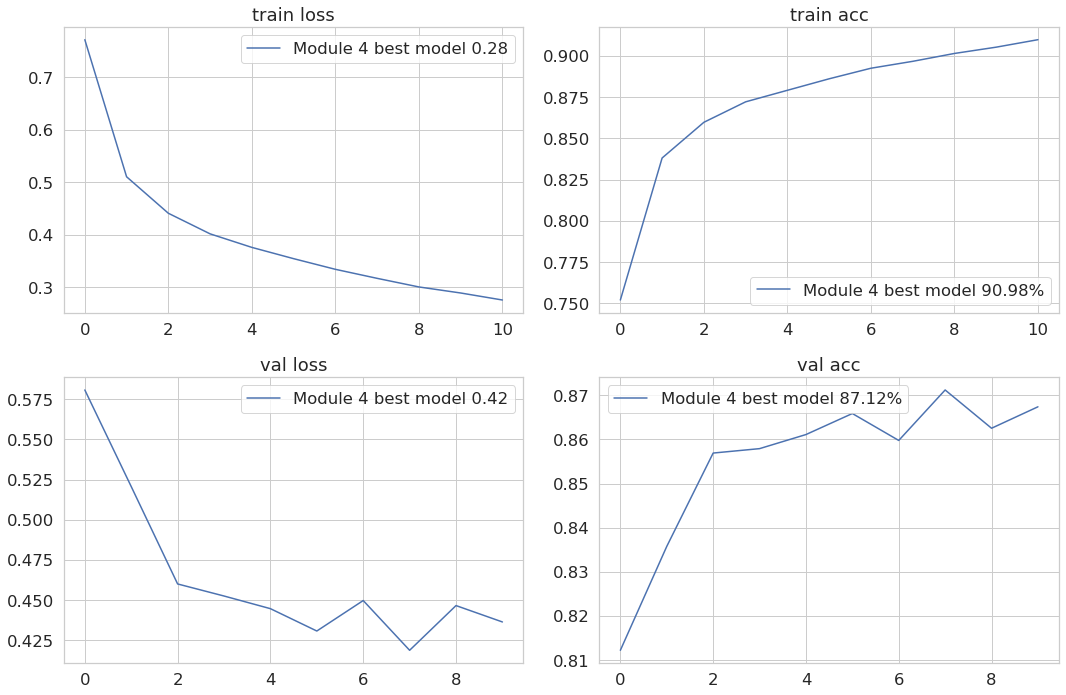

In [45]:
del model
torch.cuda.empty_cache()
plot_results([score], ['Module 4 best model'])

# Search space

W przestrzeni poszukiwań wykorzystam następujące parametry:
- Pooling
    - Max
    - Avg
- Optymalizator
    - SWATS
    - AdamW
    - AdaMod
- Liczba warstw Conv2d
    - 2, 3, 4
- Liczba warstw Dropout wykorzystujących dropratio=0.1
    - 0, 1, 2, 3
- Learning rate scheduler
    - OneCycleLr
    - Exponential
- Learning rate: 1e-5...1e-1
- Liczba warstw fully connected w klasyfikatorze
    - 1, 2, 3
- Liczba wartsw Batch Normalization

In [46]:
class Net(nn.Module):
    def __init__(self, pooling, convs, bns, fcs, dropouts):
        super(Net, self).__init__()
        
        self.pooling = pooling
        self.convs = convs
        self.bns = bns
        self.fcs = fcs
        self.dropouts = dropouts
        
        self.layers = [nn.Conv2d(1, 16, 3, padding=1),
                 nn.ReLU()]
        
        if self.pooling == 'max':
            self.layers.append(nn.MaxPool2d(2))
        else:
            self.layers.append(nn.AvgPool2d(2))
        
        for i in range(self.convs):
            if self.bns > 0:
                self.bns -= 1
                self.layers.extend([
                    nn.BatchNorm2d(2**(i+4)),
                    nn.Conv2d(2**(i+4), 2**(i+5), 3, padding=1),
                    nn.ReLU()
                ])
                
            else:
                self.layers.extend([
                    nn.Conv2d(2**(i+4), 2**(i+5), 3, padding=1),
                    nn.ReLU()
                ])
                
            if self.pooling == 'max':
                self.layers.append(nn.MaxPool2d(2))
            else:
                self.layers.append(nn.AvgPool2d(2))
                
            if self.dropouts > 0:
                self.layers.append(nn.Dropout(0.1))
                self.dropouts -= 1
                
        
        self.layers.extend([nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten()])
        
        if self.fcs > 1:
            self.layers.extend([nn.Linear(2**(convs+4), 2**(convs+4)) for _ in range(self.fcs - 1)])
        
        self.layers.append(nn.Linear(2**(convs+4), 10))
        self.model = nn.Sequential(*self.layers)
        
    def forward(self, x):
        x = self.model(x)
        output = F.log_softmax(x, dim=1)
        return output

# HPO

In [51]:
import torch_optimizer as optim
import torch.optim.lr_scheduler as lr_schedulers

device = torch.device('cuda')
def objective(trial):
    pooling = trial.suggest_categorical('pooling', ['avg', 'max'])
    convs = trial.suggest_int('convs', 1, 3)
    fcs = trial.suggest_int('FCs', 1, 3)
    dropouts = trial.suggest_int('Dropouts', 0, 3)
    
    # Define model
    model = Net(pooling, convs, bns, fcs, dropouts)
    model = model.to(device)
    
    # Generate optimizer
    optim_choice = trial.suggest_categorical('optimizer', ['adamod', 'swats', 'adamw'])
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    optimizers = {
        'adamod': optim.adamod.AdaMod, 
        'swats': optim.swats.SWATS, 
        'adamw': torch.optim.AdamW
    }
    optimizer = optimizers[optim_choice](model.parameters(), lr=lr)
    
    # Define lr scheduler
    scheduler_choice = trial.suggest_categorical('lr_scheduler', ['None', 'exponential', 'one_cycle'])
    
    # Training
    score = torch_train(model, optimizer, early_stopping=True, epochs=20, batch_size=128,
                       trial=trial, scheduler=scheduler_choice)
    return score[3][-1]

In [48]:
# Model example
n = Net('max', convs=3, bns=2, fcs=3, dropouts=3)
from torchsummary import summary
n = n.to(device)
summary(n, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
       BatchNorm2d-4           [-1, 16, 14, 14]              32
            Conv2d-5           [-1, 32, 14, 14]           4,640
              ReLU-6           [-1, 32, 14, 14]               0
         MaxPool2d-7             [-1, 32, 7, 7]               0
           Dropout-8             [-1, 32, 7, 7]               0
       BatchNorm2d-9             [-1, 32, 7, 7]              64
           Conv2d-10             [-1, 64, 7, 7]          18,496
             ReLU-11             [-1, 64, 7, 7]               0
        MaxPool2d-12             [-1, 64, 3, 3]               0
          Dropout-13             [-1, 64, 3, 3]               0
           Conv2d-14            [-1, 12

In [63]:
study = optuna.create_study(direction='maximize', study_name='Quickdraw classification optimization')
study.optimize(objective, n_trials=200, timeout=11400)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-09-23 09:09:52,833] A new study created in memory with name: Quickdraw classification optimization
Val acc: 88.43%, Val loss: 0.3744, LR 0.00400:  55%|████████▊       | 11/20 [01:40<01:22,  9.17s/it]
[I 2021-09-23 09:11:33,761] Trial 0 finished with value: 0.8784743547439575 and parameters: {'pooling': 'avg', 'convs': 3, 'BNs': 1, 'FCs': 2, 'Dropouts': 3, 'optimizer': 'swats', 'lr': 0.032072946338663755, 'lr_scheduler': 'None'}. Best is trial 0 with value: 0.8784743547439575.


Early stopped at 12 epoch. Current val_acc: 0.8843384981155396. Highest val_acc: 0.8894397616386414


Val acc: 87.15%, Val loss: 0.4160, LR 0.00054:  90%|██████████████▍ | 18/20 [02:02<00:13,  6.81s/it]
[I 2021-09-23 09:13:36,429] Trial 1 finished with value: 0.8694636225700378 and parameters: {'pooling': 'max', 'convs': 2, 'BNs': 3, 'FCs': 1, 'Dropouts': 1, 'optimizer': 'swats', 'lr': 0.004307612631115895, 'lr_scheduler': 'exponential'}. Best is trial 0 with value: 0.8784743547439575.


Early stopped at 19 epoch. Current val_acc: 0.8714659810066223. Highest val_acc: 0.8718950748443604


Val acc: 88.31%, Val loss: 0.3837, LR 0.00401: 100%|████████████████| 20/20 [01:29<00:00,  4.49s/it]
[I 2021-09-23 09:15:06,233] Trial 2 finished with value: 0.8830512166023254 and parameters: {'pooling': 'max', 'convs': 3, 'BNs': 3, 'FCs': 1, 'Dropouts': 3, 'optimizer': 'adamw', 'lr': 0.003964726376222404, 'lr_scheduler': 'one_cycle'}. Best is trial 2 with value: 0.8830512166023254.
Val acc: 86.61%, Val loss: 0.4325, LR 0.00400:  45%|███████▋         | 9/20 [01:25<01:44,  9.49s/it]
[I 2021-09-23 09:16:31,672] Trial 3 finished with value: 0.867127537727356 and parameters: {'pooling': 'max', 'convs': 3, 'BNs': 3, 'FCs': 2, 'Dropouts': 1, 'optimizer': 'swats', 'lr': 6.095801418570478e-05, 'lr_scheduler': 'None'}. Best is trial 2 with value: 0.8830512166023254.


Early stopped at 10 epoch. Current val_acc: 0.8660786151885986. Highest val_acc: 0.8732776641845703


Val acc: 87.77%, Val loss: 0.4406, LR 0.00400:  75%|████████████    | 15/20 [02:12<00:44,  8.83s/it]
[I 2021-09-23 09:18:44,096] Trial 4 finished with value: 0.8821930885314941 and parameters: {'pooling': 'avg', 'convs': 3, 'BNs': 1, 'FCs': 1, 'Dropouts': 1, 'optimizer': 'swats', 'lr': 0.00013142381968817644, 'lr_scheduler': 'None'}. Best is trial 2 with value: 0.8830512166023254.


Early stopped at 16 epoch. Current val_acc: 0.8777115345001221. Highest val_acc: 0.8861501812934875


Val acc: 64.79%, Val loss: 1.0990, LR 0.00400:   0%|                         | 0/20 [00:02<?, ?it/s]
[I 2021-09-23 09:18:46,874] Trial 5 pruned. 
Val acc: 62.05%, Val loss: 1.1904, LR 0.00400:   0%|                         | 0/20 [00:05<?, ?it/s]
[I 2021-09-23 09:18:52,364] Trial 6 pruned. 
Val acc: 81.52%, Val loss: 0.5833, LR 0.00360:   0%|                         | 0/20 [00:03<?, ?it/s]
[I 2021-09-23 09:18:55,627] Trial 7 pruned. 
Val acc: 85.24%, Val loss: 0.4646, LR 0.00400:   5%|▊                | 1/20 [00:09<02:54,  9.18s/it]
[I 2021-09-23 09:19:04,816] Trial 8 pruned. 
Val acc: 70.36%, Val loss: 0.9068, LR 0.00360:   0%|                         | 0/20 [00:04<?, ?it/s]
[I 2021-09-23 09:19:09,028] Trial 9 pruned. 
Val acc: 78.25%, Val loss: 0.6899, LR 0.00400:   0%|                         | 0/20 [00:03<?, ?it/s]
[I 2021-09-23 09:19:12,732] Trial 10 pruned. 
Val acc: 87.09%, Val loss: 0.4339, LR 0.00400:  30%|█████            | 6/20 [00:31<01:12,  5.21s/it]
[I 2021-09-23 09:19:44

Early stopped at 7 epoch. Current val_acc: 0.8708938956260681. Highest val_acc: 0.8794755339622498


Val acc: 74.42%, Val loss: 0.7968, LR 0.00400:   0%|                         | 0/20 [00:04<?, ?it/s]
[I 2021-09-23 09:19:48,327] Trial 12 pruned. 
Val acc: 78.97%, Val loss: 0.6611, LR 0.00400:   0%|                         | 0/20 [00:06<?, ?it/s]
[I 2021-09-23 09:19:54,609] Trial 13 pruned. 
Val acc: 82.89%, Val loss: 0.5362, LR 0.00400:   0%|                         | 0/20 [00:04<?, ?it/s]
[I 2021-09-23 09:19:59,209] Trial 14 pruned. 
Val acc: 81.25%, Val loss: 0.5921, LR 0.00400:   0%|                         | 0/20 [00:06<?, ?it/s]
[I 2021-09-23 09:20:05,289] Trial 15 pruned. 
Val acc: 85.85%, Val loss: 0.4407, LR 0.00400:  10%|█▋               | 2/20 [00:13<01:59,  6.66s/it]
[I 2021-09-23 09:20:18,635] Trial 16 pruned. 
Val acc: 39.17%, Val loss: 1.6946, LR 0.00400:   0%|                         | 0/20 [00:02<?, ?it/s]
[I 2021-09-23 09:20:21,267] Trial 17 pruned. 
Val acc: 81.19%, Val loss: 0.5977, LR 0.00400:   0%|                         | 0/20 [00:06<?, ?it/s]
[I 2021-09-23 09:

Early stopped at 17 epoch. Current val_acc: 0.8925387263298035. Highest val_acc: 0.8939689993858337


Val acc: 82.71%, Val loss: 0.5359, LR 0.13855:   0%|                         | 0/20 [00:06<?, ?it/s]
[I 2021-09-23 09:25:16,755] Trial 31 pruned. 
Val acc: 87.20%, Val loss: 0.3911, LR 0.00262:  15%|██▌              | 3/20 [00:32<03:05, 10.93s/it]
[I 2021-09-23 09:25:49,587] Trial 32 pruned. 
Val acc: 83.53%, Val loss: 0.5255, LR 0.00360:   0%|                         | 0/20 [00:08<?, ?it/s]
[I 2021-09-23 09:25:57,971] Trial 33 pruned. 
Val acc: 72.35%, Val loss: 0.8598, LR 0.00360:   0%|                         | 0/20 [00:07<?, ?it/s]
[I 2021-09-23 09:26:05,293] Trial 34 pruned. 
Val acc: 61.26%, Val loss: 1.2066, LR 0.00400:   0%|                         | 0/20 [00:04<?, ?it/s]
[I 2021-09-23 09:26:10,033] Trial 35 pruned. 
Val acc: 83.05%, Val loss: 0.5292, LR 0.00360:   0%|                         | 0/20 [00:09<?, ?it/s]
[I 2021-09-23 09:26:19,369] Trial 36 pruned. 
Val acc: 82.79%, Val loss: 0.5429, LR 0.00400:   0%|                         | 0/20 [00:04<?, ?it/s]
[I 2021-09-23 09:

Early stopped at 7 epoch. Current val_acc: 0.8738974928855896. Highest val_acc: 0.8795709013938904


Val acc: 86.87%, Val loss: 0.4104, LR 0.00400:  15%|██▌              | 3/20 [00:18<01:43,  6.11s/it]
[I 2021-09-23 09:27:34,047] Trial 42 pruned. 
Val acc: 85.42%, Val loss: 0.4670, LR 0.00400:  15%|██▌              | 3/20 [00:17<01:41,  5.97s/it]
[I 2021-09-23 09:27:51,988] Trial 43 pruned. 
Val acc: 86.45%, Val loss: 0.4219, LR 0.00400:  10%|█▋               | 2/20 [00:14<02:06,  7.02s/it]
[I 2021-09-23 09:28:06,048] Trial 44 pruned. 
Val acc: 87.59%, Val loss: 0.3887, LR 0.00400:  15%|██▌              | 3/20 [00:18<01:42,  6.02s/it]
[I 2021-09-23 09:28:24,145] Trial 45 pruned. 
Val acc: 86.40%, Val loss: 0.4292, LR 0.00400:  10%|█▋               | 2/20 [00:13<01:59,  6.65s/it]
[I 2021-09-23 09:28:37,482] Trial 46 pruned. 
Val acc: 84.92%, Val loss: 0.4619, LR 0.00400:   5%|▊                | 1/20 [00:09<02:53,  9.13s/it]
[I 2021-09-23 09:28:46,647] Trial 47 pruned. 
Val acc: 83.80%, Val loss: 0.5083, LR 0.00400:   0%|                         | 0/20 [00:08<?, ?it/s]
[I 2021-09-23 09:

Early stopped at 14 epoch. Current val_acc: 0.8762812614440918. Highest val_acc: 0.886340856552124


Val acc: 83.29%, Val loss: 0.5148, LR 0.00400:   0%|                         | 0/20 [00:08<?, ?it/s]
[I 2021-09-23 09:31:57,695] Trial 57 pruned. 
Val acc: 83.55%, Val loss: 0.5154, LR 0.00400:   0%|                         | 0/20 [00:08<?, ?it/s]
[I 2021-09-23 09:32:06,473] Trial 58 pruned. 
Val acc: 86.12%, Val loss: 0.4407, LR 0.00400:  10%|█▋               | 2/20 [00:24<03:43, 12.42s/it]
[I 2021-09-23 09:32:31,349] Trial 59 pruned. 
Val acc: 85.64%, Val loss: 0.4475, LR 0.00400:   5%|▊                | 1/20 [00:17<05:31, 17.43s/it]
[I 2021-09-23 09:32:48,812] Trial 60 pruned. 
Val acc: 82.63%, Val loss: 0.5502, LR 0.00400:   0%|                         | 0/20 [00:08<?, ?it/s]
[I 2021-09-23 09:32:57,123] Trial 61 pruned. 
Val acc: 83.05%, Val loss: 0.5226, LR 0.00400:   0%|                         | 0/20 [00:08<?, ?it/s]
[I 2021-09-23 09:33:05,402] Trial 62 pruned. 
Val acc: 80.44%, Val loss: 0.6120, LR 0.00400:   0%|                         | 0/20 [00:04<?, ?it/s]
[I 2021-09-23 09:

Val acc: 85.27%, Val loss: 0.4649, LR 0.00400:   5%|▊                | 1/20 [00:15<05:02, 15.92s/it]
[I 2021-09-23 09:48:16,578] Trial 159 pruned. 
Val acc: 83.77%, Val loss: 0.5128, LR 0.00400:   0%|                         | 0/20 [00:04<?, ?it/s]
[I 2021-09-23 09:48:20,954] Trial 160 pruned. 
Val acc: 87.77%, Val loss: 0.3822, LR 0.00262:  15%|██▌              | 3/20 [00:31<02:59, 10.58s/it]
[I 2021-09-23 09:48:52,737] Trial 161 pruned. 
Val acc: 82.63%, Val loss: 0.5472, LR 0.72767:   0%|                         | 0/20 [00:05<?, ?it/s]
[I 2021-09-23 09:48:58,396] Trial 162 pruned. 
Val acc: 84.13%, Val loss: 0.4902, LR 0.00324:   5%|▊                | 1/20 [00:15<05:00, 15.82s/it]
[I 2021-09-23 09:49:14,243] Trial 163 pruned. 
Val acc: 85.20%, Val loss: 0.4673, LR 0.00324:   5%|▊                | 1/20 [00:16<05:19, 16.84s/it]
[I 2021-09-23 09:49:31,112] Trial 164 pruned. 
Val acc: 85.11%, Val loss: 0.4643, LR 0.00292:  10%|█▋               | 2/20 [00:23<03:35, 11.98s/it]
[I 2021-09-

Early stopped at 17 epoch. Current val_acc: 0.8935399055480957. Highest val_acc: 0.8950655460357666


Val acc: 87.73%, Val loss: 0.3834, LR 0.00262:  15%|██▌              | 3/20 [00:31<02:59, 10.59s/it]
[I 2021-09-23 09:55:26,007] Trial 183 pruned. 
Val acc: 83.60%, Val loss: 0.5201, LR 0.00360:   0%|                         | 0/20 [00:07<?, ?it/s]
[I 2021-09-23 09:55:33,963] Trial 184 pruned. 
Val acc: 84.16%, Val loss: 0.4996, LR 0.00360:   0%|                         | 0/20 [00:08<?, ?it/s]
[I 2021-09-23 09:55:42,016] Trial 185 pruned. 
Val acc: 86.69%, Val loss: 0.4162, LR 0.00292:  10%|█▋               | 2/20 [00:23<03:33, 11.86s/it]
[I 2021-09-23 09:56:05,769] Trial 186 pruned. 
Val acc: 85.91%, Val loss: 0.4401, LR 0.00324:   5%|▊                | 1/20 [00:08<02:47,  8.82s/it]
[I 2021-09-23 09:56:14,623] Trial 187 pruned. 
Val acc: 82.93%, Val loss: 0.5297, LR 0.00360:   0%|                         | 0/20 [00:07<?, ?it/s]
[I 2021-09-23 09:56:22,621] Trial 188 pruned. 
Val acc: 86.70%, Val loss: 0.4178, LR 0.00292:  10%|█▋               | 2/20 [00:12<01:56,  6.50s/it]
[I 2021-09-

Study statistics: 
  Number of finished trials:  200
  Number of pruned trials:  190
  Number of complete trials:  10
Best trial:
  Value:  0.8929201364517212
  Params: 
    pooling: avg
    convs: 3
    BNs: 1
    FCs: 1
    Dropouts: 3
    optimizer: swats
    lr: 0.023897960496886948
    lr_scheduler: exponential


In [55]:
# best found model
model = Net(pooling='avg', convs=3, bns=1, fcs=1, dropouts=3)
model.to(device)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         AvgPool2d-3           [-1, 16, 14, 14]               0
       BatchNorm2d-4           [-1, 16, 14, 14]              32
            Conv2d-5           [-1, 32, 14, 14]           4,640
              ReLU-6           [-1, 32, 14, 14]               0
         AvgPool2d-7             [-1, 32, 7, 7]               0
           Dropout-8             [-1, 32, 7, 7]               0
            Conv2d-9             [-1, 64, 7, 7]          18,496
             ReLU-10             [-1, 64, 7, 7]               0
        AvgPool2d-11             [-1, 64, 3, 3]               0
          Dropout-12             [-1, 64, 3, 3]               0
           Conv2d-13            [-1, 128, 3, 3]          73,856
             ReLU-14            [-1, 12

In [ ]:
# best optimizer
optimizer = optim.swats.SWATS(model.parameters(), lr=0.023898)
scheduler = 'exponential'
score2 = torch_train(model, optimizer, early_stopping=True, epochs=30, batch_size=128, 
                    save_models=True, trial=None, scheduler=scheduler)

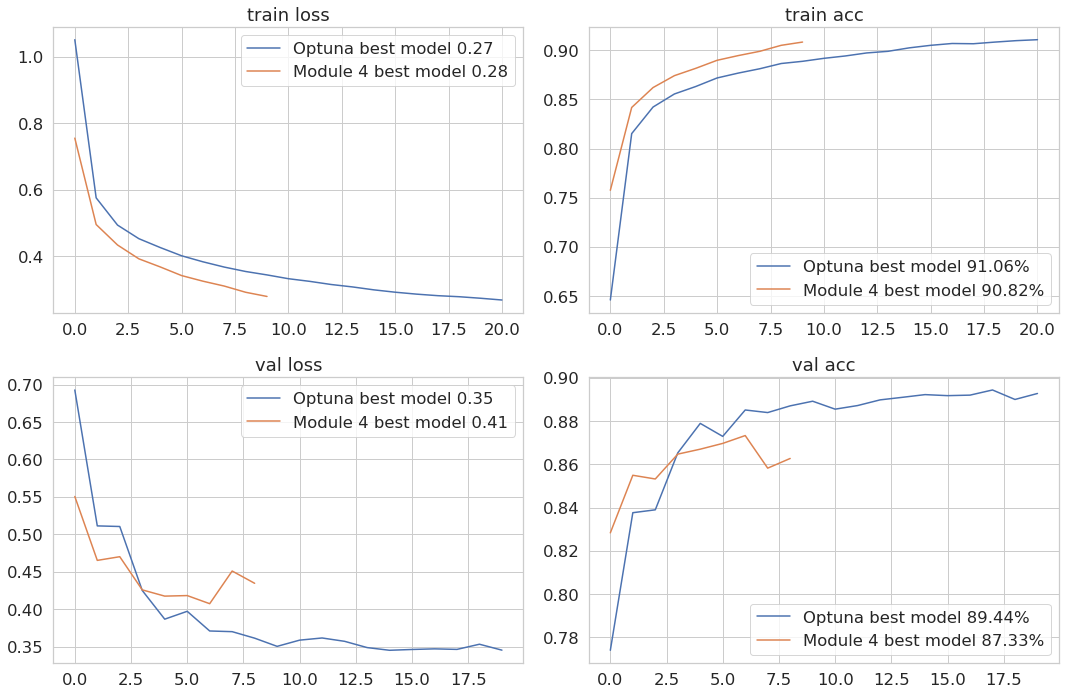

In [24]:
del model
torch.cuda.empty_cache()
plot_results([score, score2], ['Module 4 best model', 'Optuna best model'])

## Architecture search with AutoKeras

In [71]:
!pip install autokeras

     |████████████████████████████████| 166 kB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 4.8 MB/s  eta 0:00:01
     |████████████████████████████████| 14.9 MB 11.0 MB/s eta 0:00:01


  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.0
    Uninstalling typing-extensions-3.10.0.0:
      Successfully uninstalled typing-extensions-3.10.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imgaug 0.4.0 requires opencv-python-headless, which is not installed.
albumentations 1.0.3 requires opencv-python-headless>=4.1.1, which is not installed.
aiohttp 3.7.4.post0 requires chardet<5.0,>=2.0, which is not installed.


In [1]:
import tensorflow as tf
import autokeras as  ak

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

2021-09-23 11:30:40.968154: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-09-23 11:30:42.947081: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-09-23 11:30:43.003174: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-23 11:30:43.003587: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 computeCapability: 6.1
coreClock: 1.6705GHz coreCount: 10 deviceMemorySize: 5.94GiB deviceMemoryBandwidth: 178.99GiB/s
2021-09-23 11:30:43.003620: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-09-23 11:30:43.006637: I tensorflow/stream_executor/

In [90]:
# adjust data shape for tensorflow
X_train = X_train.squeeze()
X_val = X_val.squeeze()

In [19]:
input_node = ak.ImageInput()
output_node = ak.ImageBlock(
    block_type="resnet",
    normalize=True,
    augment=True,
    )(input_node)

output_node = ak.ClassificationHead()(output_node)

clf = ak.AutoModel(
    inputs=input_node, 
    outputs=output_node, 
    overwrite=True, 
    max_trials=5,
    objective='val_accuracy',
)
clf.fit(X_train, y_train, epochs=15)

Trial 5 Complete [02h 36m 21s]
val_accuracy: 0.5086798369884491

Best val_accuracy So Far: 0.8177533745765686
Total elapsed time: 04h 20m 14s
INFO:tensorflow:Oracle triggered exit
Epoch 1/15
2622/2622 [==============================] - 154s 57ms/step - loss: 1.8036 - accuracy: 0.3828
Epoch 2/15
2622/2622 [==============================] - 149s 57ms/step - loss: 1.3390 - accuracy: 0.5537
Epoch 3/15
2622/2622 [==============================] - 149s 57ms/step - loss: 1.1015 - accuracy: 0.6354
Epoch 4/15
2622/2622 [==============================] - 150s 57ms/step - loss: 0.9393 - accuracy: 0.6906
Epoch 5/15
2622/2622 [==============================] - 160s 61ms/step - loss: 0.8223 - accuracy: 0.7315
Epoch 6/15
2622/2622 [==============================] - 148s 56ms/step - loss: 0.7346 - accuracy: 0.7601
Epoch 7/15
2622/2622 [==============================] - 146s 56ms/step - loss: 0.6637 - accuracy: 0.7850
Epoch 8/15
2622/2622 [==============================] - 146s 56ms/step - loss: 0.6098

2021-09-23 17:46:37.835847: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/home/jakub/anaconda3/envs/deep_learning/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


In [105]:
# longer training
from tensorflow import keras
model = keras.models.load_model('./auto_model/best_model/')

In [123]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, 
          y_train, 
          epochs=30, 
          callbacks=tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=4,
            verbose=1),
          validation_data=(X_val, y_val),
         shuffle=True)

Epoch 1/30
2622/2622 [==============================] - 162s 60ms/step - loss: 0.7826 - accuracy: 0.7637 - val_loss: 0.6393 - val_accuracy: 0.8008
Epoch 2/30
2622/2622 [==============================] - 159s 61ms/step - loss: 0.6344 - accuracy: 0.8038 - val_loss: 0.6451 - val_accuracy: 0.7917
Epoch 3/30
2622/2622 [==============================] - 166s 63ms/step - loss: 0.5503 - accuracy: 0.8269 - val_loss: 0.4906 - val_accuracy: 0.8424
Epoch 4/30
2622/2622 [==============================] - 167s 64ms/step - loss: 0.5365 - accuracy: 0.8340 - val_loss: 0.4824 - val_accuracy: 0.8468
Epoch 5/30
2622/2622 [==============================] - 164s 63ms/step - loss: 0.4921 - accuracy: 0.8450 - val_loss: 0.4509 - val_accuracy: 0.8584
Epoch 6/30
2622/2622 [==============================] - 167s 64ms/step - loss: 0.4536 - accuracy: 0.8555 - val_loss: 0.4249 - val_accuracy: 0.8654
Epoch 7/30
2622/2622 [==============================] - 167s 64ms/step - loss: 0.4281 - accuracy: 0.8638 - val_loss: 0

In [99]:
best_ak_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
cast_to_float32 (CastToFloat32) (None, 28, 28, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 28, 28, 1)    3           cast_to_float32[0][0]            
__________________________________________________________________________________________________
random_flip (RandomFlip)        (None, 28, 28, 1)    0           normalization[0][0]              
______________________________________________________________________________________________

In [84]:
X_val = X_val.squeeze()

In [124]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print('Val loss: {:.4f}, Val acc: {:.3f}%'.format(val_loss, 100*val_acc))

656/656 [==============================] - 10s 15ms/step - loss: 0.3641 - accuracy: 0.8884
Val loss: 0.3641, Val acc: 88.839%


# Summary / extra

### Best architectures
 - Module 4 best model

In [62]:
summary(NetBN().to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 32, 24, 24]           2,336
              ReLU-5           [-1, 32, 24, 24]               0
         MaxPool2d-6           [-1, 32, 12, 12]               0
            Conv2d-7           [-1, 64, 10, 10]          18,496
              ReLU-8           [-1, 64, 10, 10]               0
         MaxPool2d-9             [-1, 64, 5, 5]               0
           Conv2d-10            [-1, 128, 3, 3]          73,856
             ReLU-11            [-1, 128, 3, 3]               0
          Flatten-12                 [-1, 1152]               0
           Linear-13                   [-1, 10]          11,530
Total params: 106,314
Trainable params:

 - Optuna best model

In [63]:
summary(Net(pooling='avg', convs=3, bns=1, fcs=1, dropouts=3).to(device),
       (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         AvgPool2d-3           [-1, 16, 14, 14]               0
       BatchNorm2d-4           [-1, 16, 14, 14]              32
            Conv2d-5           [-1, 32, 14, 14]           4,640
              ReLU-6           [-1, 32, 14, 14]               0
         AvgPool2d-7             [-1, 32, 7, 7]               0
           Dropout-8             [-1, 32, 7, 7]               0
            Conv2d-9             [-1, 64, 7, 7]          18,496
             ReLU-10             [-1, 64, 7, 7]               0
        AvgPool2d-11             [-1, 64, 3, 3]               0
          Dropout-12             [-1, 64, 3, 3]               0
           Conv2d-13            [-1, 128, 3, 3]          73,856
             ReLU-14            [-1, 12

 - AutoKeras best model

In [64]:
best_ak_model = clf.export_model()
best_ak_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
cast_to_float32 (CastToFloat32) (None, 28, 28, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 28, 28, 1)    3           cast_to_float32[0][0]            
__________________________________________________________________________________________________
random_flip (RandomFlip)        (None, 28, 28, 1)    0           normalization[0][0]              
______________________________________________________________________________________________

In [127]:
from prettytable import PrettyTable
summary = PrettyTable()

# ak_model_params
trainableParams = np.sum([np.prod(v.get_shape()) for v in best_ak_model.trainable_weights])
nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in best_ak_model.non_trainable_weights])
ak_model_params = trainableParams + nonTrainableParams

summary.field_names = ['Model_name', 'Parameters', 'Val accuracy']
summary.add_row(['Optuna', count_model_params(Net(pooling='avg', convs=3, bns=1, fcs=1, dropouts=3)), '89.44%'])
summary.add_row(['AutoKeras', int(ak_model_params), '88.39%'])
summary.add_row(['Module 4', count_model_params(NetBN()), '87.12%'])
summary.title = 'HPO Results'
print(summary)

+----------------------------------------+
|              HPO Results               |
+------------+------------+--------------+
| Model_name | Parameters | Val accuracy |
+------------+------------+--------------+
|   Optuna   |   98474    |    89.44%    |
| AutoKeras  |  23585293  |    88.39%    |
|  Module 4  |   106314   |    87.12%    |
+------------+------------+--------------+


# Wyślij rozwiązanie
Możesz skorzystać z jednego z poniższych sposobów:
**mailem na specjalny adres** ze strony pracy domowej w panelu programu prześlij jedno z poniższych:
- notebooka (jeżeli plik ma mniej niż np. 10MB)
- notebooka w zipie
- link do Colaba (udostępniony)
- link do pliku przez GDrive/Dropboxa/WeTransfer/...
- pdfa (poprzez download as pdf)
- jako plik w repozytorium na np. GitHubie, by budować swoje portfolio (wtedy uważaj na wielkość pliku, najlepiej kilka MB, Max 25MB)

Najlepiej, by w notebooku było widać wyniki uruchomienia komórek, chyba, że przez nie plik będzie mieć 100+MB wtedy najlepiej Colab lub jakieś przemyślenie co poszło nie tak (zbyt dużo dużych zdjęć wyświetlonych w komórkach).

## Co otrzymasz?
Informację zwrotną z ewentualnymi sugestiami, komentarzami.